In [11]:
import cv2
import numpy as np
from PIL import Image
import os
from collections import Counter
from sklearn.cluster import KMeans

# Загрузка изображения
image_path = 'blood_analysis_dataset_540/processed/5256043418088498597.jpg'
image = Image.open(image_path)

# Вычисление новых размеров с сохранением пропорций
width = 900
ratio = width / float(image.size[0])
height = int(float(image.size[1]) * ratio)

# Изменение размера изображения с использованием LANCZOS
resized_image = image.resize((width, height), Image.Resampling.LANCZOS)

# Формирование нового имени файла
directory, filename = os.path.split(image_path)
name, ext = os.path.splitext(filename)
new_filename = f"{name}_resized{ext}"
new_image_path = os.path.join('resized_data/', new_filename)

# Сохранение измененного изображения
resized_image.save(new_image_path)

# Опционально: показ изображения
resized_image.show()

name1 = new_image_path

# Функция для вычисления угла линии
def calculate_angle(x1, y1, x2, y2):
    return np.degrees(np.arctan2(y2 - y1, x2 - x1))

# Функция для вычисления расстояния между двумя точками
def calculate_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

# Функция для вычисления длины линии
def calculate_line_length(x1, y1, x2, y2):
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

# Функция для объединения близких линий
def merge_close_lines(lines, distance_threshold=4, angle_threshold=5):
    merged_lines = []
    used_indices = set()

    for i, line1 in enumerate(lines):
        if i in used_indices:
            continue

        x1, y1, x2, y2 = line1
        angle1 = calculate_angle(x1, y1, x2, y2)
        group = [line1]

        for j, line2 in enumerate(lines[i + 1:], start=i + 1):
            if j in used_indices:
                continue

            x3, y3, x4, y4 = line2
            angle2 = calculate_angle(x3, y3, x4, y4)

            if abs(angle1 - angle2) > angle_threshold:
                continue

            center1 = ((x1 + x2) / 2, (y1 + y2) / 2)
            center2 = ((x3 + x4) / 2, (y3 + y4) / 2)
            distance = calculate_distance(center1, center2)

            if distance > distance_threshold:
                continue

            group.append(line2)
            used_indices.add(j)

        if group:
            avg_line = np.mean(group, axis=0).astype(int)
            merged_lines.append(avg_line)
            used_indices.add(i)

    return merged_lines

# Функция для нахождения точки пересечения двух линий
def line_intersection(line1, line2):
    x1, y1, x2, y2 = line1
    x3, y3, x4, y4 = line2

    A1 = y2 - y1
    B1 = x1 - x2
    C1 = A1 * x1 + B1 * y1

    A2 = y4 - y3
    B2 = x3 - x4
    C2 = A2 * x3 + B2 * y3

    determinant = A1 * B2 - A2 * B1

    if determinant == 0:
        return None  # Линии параллельны
    else:
        x = (B2 * C1 - B1 * C2) / determinant
        y = (A1 * C2 - A2 * C1) / determinant
        return int(x), int(y)

# Функция для вычисления центра линии
def calculate_center(x1, y1, x2, y2):
    return ((x1 + x2) // 2, (y1 + y2) // 2)

# Функция для получения доминирующего цвета
def get_dominant_color(image_path, num_colors=1):
    image = Image.open(image_path)
    image = image.resize((150, 150))
    image_array = np.array(image)
    pixels = image_array.reshape(-1, image_array.shape[-1])
    if pixels.shape[1] == 4:
        pixels = pixels[:, :3]
    color_counts = Counter(map(tuple, pixels))
    dominant_color = color_counts.most_common(num_colors)[0][0]
    return dominant_color

# Функция для проверки параллельности линий
def are_lines_parallel(lines, angle_threshold=2):
    if len(lines) < 0.1:
        return False

    angles = []
    for line in lines[:2]:  # Проверяем только первые две линии
        x1, y1, x2, y2 = line
        angle = calculate_angle(x1, y1, x2, y2)
        angles.append(angle)

    return abs(angles[0] - angles[1]) <= angle_threshold

# Основной код обработки изображения
def process_image(image_path):
    # Загрузка изображения
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Применение Canny edge detection
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    # Применение Hough Line Transform
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=50, maxLineGap=10)

    # Преобразование линий в нужный формат
    if lines is None:
        print("Линии не обнаружены. Возвращаем исходное изображение.")
        return image

    lines = [line[0] for line in lines]

    # Объединение близких линий
    merged_lines = merge_close_lines(lines, distance_threshold=4, angle_threshold=5)

    # Проверяем, параллельны ли линии
    if are_lines_parallel(merged_lines):
        print("Линии параллельны или отклоняются не более чем на 2 градуса. Применяем поворот.")
        return apply_rotation(image, image_path, merged_lines)
    else:
        print("Линии не параллельны. Применяем коррекцию перспективы.")
        return apply_perspective_correction(image, image_path, merged_lines)

# Функция для применения поворота
def apply_rotation(image, image_path, lines):
    # Вычисляем средний угол поворота
    if len(lines) >= 1:
        line1 = lines[0]
        line2 = lines[1]

        angle1 = calculate_angle(*line1)
        angle2 = calculate_angle(*line2)
        average_angle = (angle1 + angle2) / 2
    else:
        average_angle = 0

    # Получаем доминирующий цвет
    dominant_color = get_dominant_color(image_path)
    if isinstance(dominant_color, (tuple, list, np.ndarray)):
        dominant_color = tuple(map(int, dominant_color))
    else:
        dominant_color = (int(dominant_color),) * 3

    # Вычисляем матрицу поворота
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, average_angle, 1.0)

    # Вычисляем новые размеры холста после поворота
    cos = np.abs(rotation_matrix[0, 0])
    sin = np.abs(rotation_matrix[0, 1])
    new_w = int((h * sin) + (w * cos))
    new_h = int((h * cos) + (w * sin))

    # Корректируем матрицу поворота для учета нового холста
    rotation_matrix[0, 2] += (new_w / 2) - center[0]
    rotation_matrix[1, 2] += (new_h / 2) - center[1]

    # Применяем поворот к изображению с новыми размерами холста
    rotated_image = cv2.warpAffine(
        image,
        rotation_matrix,
        (new_w, new_h),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=dominant_color
    )

    return rotated_image

# Функция для применения коррекции перспективы
def apply_perspective_correction(image, image_path, lines):
    # Создаем копию изображения для рисования линий
    output_image = image.copy()

    # Получаем высоту и ширину изображения
    image_height, image_width, _ = image.shape

    # Словарь для хранения центров линий
    line_centers = {}

    # Отрисовка всех линий и сохранение их центров
    for i, line in enumerate(lines):
        x1, y1, x2, y2 = line
        center = calculate_center(x1, y1, x2, y2)
        line_centers[i] = center

    # Фильтрация горизонтальных линий (угол от -40 до 40 градусов)
    middle_third_width_start = image_width // 3
    middle_third_width_end = 2 * image_width // 3
    min_horizontal_line_length = image_width / 4

    # Фильтр исключения линий с центрами ближе 20 пикселей к границам
    horizontal_lines = {
        line_id: center for line_id, center in line_centers.items()
        if (middle_third_width_start <= center[0] <= middle_third_width_end) and
           (calculate_line_length(*lines[line_id]) >= min_horizontal_line_length) and
           (-40 <= calculate_angle(*lines[line_id]) <= 40) and
           (20 <= center[0] <= image_width - 20) and  # Фильтр по X
           (25 <= center[1] <= image_height - 20)  # Фильтр по Y
    }

    # Фильтрация вертикальных линий (угол от 50 до 130 градусов)
    middle_third_height_start = image_height // 3
    middle_third_height_end = 2 * image_height // 3
    min_vertical_line_length = image_height / 9

    # Фильтр исключения линий с центрами ближе 20 пикселей к границам
    vertical_lines = {
        line_id: center for line_id, center in line_centers.items()
        if (middle_third_height_start <= center[1] <= middle_third_height_end) and
           (calculate_line_length(*lines[line_id]) >= min_vertical_line_length) and
           (50 <= abs(calculate_angle(*lines[line_id])) <= 130) and
           (20 <= center[0] <= image_width - 20) and  # Фильтр по X
           (20 <= center[1] <= image_height - 20)  # Фильтр по Y
    }

    # Нахождение двух горизонтальных и двух вертикальных линий
    if horizontal_lines and vertical_lines:
        # Выбираем две горизонтальные линии (с минимальным и максимальным Y)
        min_y_line = min(horizontal_lines.items(), key=lambda item: item[1][1])
        max_y_line = max(horizontal_lines.items(), key=lambda item: item[1][1])

        # Выбираем две вертикальные линии (с минимальным и максимальным X)
        min_x_line = min(vertical_lines.items(), key=lambda item: item[1][0])
        max_x_line = max(vertical_lines.items(), key=lambda item: item[1][0])

        # Получаем координаты линий
        h_line1 = lines[min_y_line[0]]
        h_line2 = lines[max_y_line[0]]
        v_line1 = lines[min_x_line[0]]
        v_line2 = lines[max_x_line[0]]

        # Находим точки пересечения
        intersection_A = line_intersection(h_line1, v_line1)  # Левая верхняя
        intersection_B = line_intersection(h_line2, v_line1)  # Левая нижняя
        intersection_C = line_intersection(h_line1, v_line2)  # Правая верхняя
        intersection_D = line_intersection(h_line2, v_line2)  # Правая нижняя

        # Проверка, что точки пересечения найдены
        if intersection_A and intersection_B and intersection_C and intersection_D:
            # Увеличение изображения
            padding = 0  # Отступ для увеличения изображения
            output_image = cv2.copyMakeBorder(output_image, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=(0, 0, 0))

            # Смещение координат точек пересечения
            intersection_A = (intersection_A[0] + padding, intersection_A[1] + padding)
            intersection_B = (intersection_B[0] + padding, intersection_B[1] + padding)
            intersection_C = (intersection_C[0] + padding, intersection_C[1] + padding)
            intersection_D = (intersection_D[0] + padding, intersection_D[1] + padding)

            # Вычисление центра изображения
            center_x = image_width // 2
            center_y = image_height // 2

            # Вычисление реальных размеров прямоугольника (примерные значения)
            real_width = 1.0  # Предполагаемая реальная ширина (в условных единицах)
            real_height = 1.0  # Предполагаемая реальная высота (в условных единицах)

            # Масштабирование реальных размеров для отображения на изображении
            scale_factor = 1000  # 1 метр = 100 пикселей
            rect_width_px = int(real_width * scale_factor)
            rect_height_px = int(real_height * scale_factor)

            # Вычисление координат реального прямоугольника
            rect_top_left = (center_x - rect_width_px // 2, center_y - rect_height_px // 2)
            rect_bottom_right = (center_x + rect_width_px // 2, center_y + rect_height_px // 2)

            # Координаты точек A'', B'', C'', D'' для масштабированного прямоугольника
            scaled_rect_A_double_prime = (rect_top_left[0], rect_top_left[1])
            scaled_rect_B_double_prime = (rect_top_left[0], rect_bottom_right[1])
            scaled_rect_C_double_prime = (rect_bottom_right[0], rect_top_left[1])
            scaled_rect_D_double_prime = (rect_bottom_right[0], rect_bottom_right[1])

            # Вычисление преобразования перспективы
            # Исходные точки (A, B, C, D)
            pts1 = np.float32([intersection_A, intersection_B, intersection_C, intersection_D])

            # Целевые точки (A'', B'', C'', D'')
            pts2 = np.float32([scaled_rect_A_double_prime, scaled_rect_B_double_prime,
                              scaled_rect_C_double_prime, scaled_rect_D_double_prime])

            # Вычисляем матрицу преобразования перспективы
            M = cv2.getPerspectiveTransform(pts1, pts2)

            # Определяем размеры выходного изображения
            h, w = image.shape[:2]
            corners = np.float32([[0, 0], [w, 0], [w, h], [0, h]])
            transformed_corners = cv2.perspectiveTransform(np.array([corners]), M)[0]

            # Вычисляем новые размеры изображения
            x_min = int(np.min(transformed_corners[:, 0]))
            x_max = int(np.max(transformed_corners[:, 0]))
            y_min = int(np.min(transformed_corners[:, 1]))
            y_max = int(np.max(transformed_corners[:, 1]))

            new_width = x_max - x_min
            new_height = y_max - y_min

            # Создаем матрицу сдвига для корректировки обрезания
            shift_matrix = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]])

            # Объединяем матрицу преобразования и сдвига
            M_shifted = shift_matrix @ M

            # Определяем доминирующий цвет
            def get_dominant_color_kmeans(image, k=1):
                pixels = image.reshape(-1, 3)
                kmeans = KMeans(n_clusters=k, n_init=10)
                kmeans.fit(pixels)
                dominant_color = kmeans.cluster_centers_[0].astype(int)
                return dominant_color

            dominant_color = get_dominant_color_kmeans(image)

            # Применяем преобразование перспективы
            warped_image = cv2.warpPerspective(image, M_shifted, (new_width, new_height))

            # Обработка добавленных областей
            mask = (warped_image == 0).all(axis=2).astype(np.uint8) * 255
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            min_area = 40
            for contour in contours:
                if cv2.contourArea(contour) >= min_area:
                    contour_mask = np.zeros_like(mask)
                    cv2.drawContours(contour_mask, [contour], -1, 255, thickness=cv2.FILLED)
                    kernel = np.ones((5, 5), np.uint8)
                    expanded_contour_mask = cv2.dilate(contour_mask, kernel, iterations=1)
                    warped_image[expanded_contour_mask == 255] = dominant_color
                    border_mask = cv2.Canny(contour_mask, 100, 200)
                    border_mask = cv2.dilate(border_mask, None, iterations=2)
                    blurred = cv2.GaussianBlur(warped_image, (15, 15), 0)
                    warped_image[border_mask == 255] = blurred[border_mask == 255]

            return warped_image

    # Если не удалось найти пересечения, возвращаем исходное изображение
    return image

# Обработка изображения
result_image = process_image(name1)

# Сохранение результата
directory, filename = os.path.split(image_path)
name, ext = os.path.splitext(filename)
output_filename = f"{name}_processed{ext}"
output_path = os.path.join('Output_data/', output_filename)
cv2.imwrite(output_path, result_image)

# Показ результата
cv2.imshow('Processed Image', result_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

print(f"Обработка завершена. Результат сохранен в файл '{output_path}'.")

Линии параллельны или отклоняются не более чем на 2 градуса. Применяем поворот.
Обработка завершена. Результат сохранен в файл 'Output_data/5256043418088498597_processed.jpg'.


Пакетный вариант

In [5]:
import cv2
import numpy as np
from PIL import Image
import os
from collections import Counter
from sklearn.cluster import KMeans

# Конфигурация
INPUT_FOLDER = 'input_data'          # Папка с исходными изображениями
RESIZED_FOLDER = 'resized_data'      # Папка для уменьшенных копий
OUTPUT_FOLDER = 'output_data'        # Папка для результатов
SCALE_FACTOR = 1000                  # Коэффициент масштабирования
MIN_LINE_LENGTH = 50                 # Минимальная длина линии
MAX_LINE_GAP = 10                    # Максимальный разрыв линии

# Создаем папки, если они не существуют
os.makedirs(INPUT_FOLDER, exist_ok=True)
os.makedirs(RESIZED_FOLDER, exist_ok=True)
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Функция для вычисления угла линии
def calculate_angle(x1, y1, x2, y2):
    return np.degrees(np.arctan2(y2 - y1, x2 - x1))

# Функция для вычисления расстояния между точками
def calculate_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# Функция для вычисления длины линии
def calculate_line_length(x1, y1, x2, y2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

# Функция для объединения близких линий
def merge_close_lines(lines, distance_threshold=4, angle_threshold=5):
    merged_lines = []
    used_indices = set()

    for i, line1 in enumerate(lines):
        if i in used_indices:
            continue

        x1, y1, x2, y2 = line1
        angle1 = calculate_angle(x1, y1, x2, y2)
        group = [line1]

        for j, line2 in enumerate(lines[i+1:], start=i+1):
            if j in used_indices:
                continue

            x3, y3, x4, y4 = line2
            angle2 = calculate_angle(x3, y3, x4, y4)

            if abs(angle1 - angle2) > angle_threshold:
                continue

            center1 = ((x1 + x2)/2, (y1 + y2)/2)
            center2 = ((x3 + x4)/2, (y3 + y4)/2)
            distance = calculate_distance(center1, center2)

            if distance > distance_threshold:
                continue

            group.append(line2)
            used_indices.add(j)

        if group:
            avg_line = np.mean(group, axis=0).astype(int)
            merged_lines.append(avg_line)
            used_indices.add(i)

    return merged_lines

# Функция для нахождения точки пересечения линий
def line_intersection(line1, line2):
    x1, y1, x2, y2 = line1
    x3, y3, x4, y4 = line2

    A1 = y2 - y1
    B1 = x1 - x2
    C1 = A1 * x1 + B1 * y1

    A2 = y4 - y3
    B2 = x3 - x4
    C2 = A2 * x3 + B2 * y3

    determinant = A1 * B2 - A2 * B1

    if determinant == 0:
        return None
    else:
        x = (B2 * C1 - B1 * C2) / determinant
        y = (A1 * C2 - A2 * C1) / determinant
        return int(x), int(y)

# Функция для получения доминирующего цвета
def get_dominant_color(image_path, num_colors=1):
    image = Image.open(image_path)
    image = image.resize((150, 150))
    image_array = np.array(image)
    pixels = image_array.reshape(-1, image_array.shape[-1])
    if pixels.shape[1] == 4:
        pixels = pixels[:, :3]
    color_counts = Counter(map(tuple, pixels))
    dominant_color = color_counts.most_common(num_colors)[0][0]
    return dominant_color

# Функция для проверки параллельности линий
def are_lines_parallel(lines, angle_threshold=2):
    if len(lines) < 2:
        return False

    angles = []
    for line in lines[:2]:
        x1, y1, x2, y2 = line
        angle = calculate_angle(x1, y1, x2, y2)
        angles.append(angle)

    return abs(angles[0] - angles[1]) <= angle_threshold

# Функция для обработки одного изображения
def process_single_image(image_path):
    # Подготовка изображения
    image = Image.open(image_path)
    width = 900
    ratio = width / float(image.size[0])
    height = int(float(image.size[1]) * ratio)
    resized_image = image.resize((width, height), Image.Resampling.LANCZOS)

    # Сохранение уменьшенной копии
    filename = os.path.basename(image_path)
    name, ext = os.path.splitext(filename)
    resized_path = os.path.join(RESIZED_FOLDER, f"{name}_resized{ext}")
    resized_image.save(resized_path)

    # Загрузка для OpenCV
    cv_image = cv2.imread(resized_path)
    gray = cv2.cvtColor(cv_image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    # Поиск линий
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=100,
                          minLineLength=MIN_LINE_LENGTH, maxLineGap=MAX_LINE_GAP)

    if lines is None:
        print(f"Не удалось найти линии на изображении {filename}")
        return None

    lines = [line[0] for line in lines]
    merged_lines = merge_close_lines(lines)

    # Определение стратегии обработки
    if are_lines_parallel(merged_lines):
        print(f"Применяем поворот для {filename}")
        return apply_rotation(cv_image, image_path, merged_lines)
    else:
        print(f"Применяем коррекцию перспективы для {filename}")
        return apply_perspective_correction(cv_image, image_path, merged_lines)

# Функция для применения поворота
def apply_rotation(image, image_path, lines):
    if len(lines) >= 2:
        line1, line2 = lines[:2]
        angle1 = calculate_angle(*line1)
        angle2 = calculate_angle(*line2)
        average_angle = (angle1 + angle2) / 2
    else:
        average_angle = 0

    dominant_color = get_dominant_color(image_path)
    if isinstance(dominant_color, (tuple, list, np.ndarray)):
        dominant_color = tuple(map(int, dominant_color))
    else:
        dominant_color = (int(dominant_color),) * 3

    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, average_angle, 1.0)

    cos = np.abs(rotation_matrix[0, 0])
    sin = np.abs(rotation_matrix[0, 1])
    new_w = int((h * sin) + (w * cos))
    new_h = int((h * cos) + (w * sin))

    rotation_matrix[0, 2] += (new_w / 2) - center[0]
    rotation_matrix[1, 2] += (new_h / 2) - center[1]

    rotated_image = cv2.warpAffine(
        image,
        rotation_matrix,
        (new_w, new_h),
        flags=cv2.INTER_LANCZOS4,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=dominant_color
    )

    return rotated_image

# Функция для коррекции перспективы
def apply_perspective_correction(image, image_path, lines):
    output_image = image.copy()
    h, w = image.shape[:2]

    # Фильтрация линий
    line_centers = {}
    for i, line in enumerate(lines):
        x1, y1, x2, y2 = line
        center = ((x1 + x2) // 2, (y1 + y2) // 2)
        line_centers[i] = center

    # Горизонтальные линии
    horizontal_lines = {
        line_id: center for line_id, center in line_centers.items()
        if (w//3 <= center[0] <= 2*w//3) and
           (calculate_line_length(*lines[line_id]) >= w/4) and
           (-40 <= calculate_angle(*lines[line_id]) <= 40) and
           (20 <= center[0] <= w-20) and
           (25 <= center[1] <= h-20)
    }

    # Вертикальные линии
    vertical_lines = {
        line_id: center for line_id, center in line_centers.items()
        if (h//3 <= center[1] <= 2*h//3) and
           (calculate_line_length(*lines[line_id]) >= h/9) and
           (50 <= abs(calculate_angle(*lines[line_id])) <= 130) and
           (20 <= center[0] <= w-20) and
           (20 <= center[1] <= h-20)
    }

    if not horizontal_lines or not vertical_lines:
        print("Не найдено достаточно линий для коррекции перспективы")
        return image

    # Выбираем линии
    min_y_line = min(horizontal_lines.items(), key=lambda item: item[1][1])
    max_y_line = max(horizontal_lines.items(), key=lambda item: item[1][1])
    min_x_line = min(vertical_lines.items(), key=lambda item: item[1][0])
    max_x_line = max(vertical_lines.items(), key=lambda item: item[1][0])

    h_line1 = lines[min_y_line[0]]
    h_line2 = lines[max_y_line[0]]
    v_line1 = lines[min_x_line[0]]
    v_line2 = lines[max_x_line[0]]

    # Точки пересечения
    A = line_intersection(h_line1, v_line1)
    B = line_intersection(h_line2, v_line1)
    C = line_intersection(h_line1, v_line2)
    D = line_intersection(h_line2, v_line2)

    if not all([A, B, C, D]):
        print("Не удалось найти все точки пересечения")
        return image

    # Целевые точки с учетом масштаба
    width = int(calculate_distance(A, C) * SCALE_FACTOR / 100)
    height = int(calculate_distance(A, B) * SCALE_FACTOR / 100)

    pts1 = np.float32([A, B, C, D])
    pts2 = np.float32([
        [0, 0],
        [0, height],
        [width, 0],
        [width, height]
    ])

    # Матрица преобразования
    M = cv2.getPerspectiveTransform(pts1, pts2)

    # Применение преобразования
    warped = cv2.warpPerspective(
        image,
        M,
        (width, height),
        flags=cv2.INTER_LANCZOS4,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=(255, 255, 255)
    )

    return warped

# Основная функция для обработки всех изображений
def process_all_images():
    image_files = [f for f in os.listdir(INPUT_FOLDER) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    for filename in image_files:
        print(f"\nОбработка файла: {filename}")
        image_path = os.path.join(INPUT_FOLDER, filename)

        try:
            result = process_single_image(image_path)
            if result is not None:
                output_path = os.path.join(OUTPUT_FOLDER, f"corrected_{filename}")
                cv2.imwrite(output_path, result)
                print(f"Результат сохранен в: {output_path}")
        except Exception as e:
            print(f"Ошибка при обработке {filename}: {str(e)}")

# Запуск обработки
if __name__ == "__main__":
    print("Начало обработки изображений...")
    process_all_images()
    print("\nОбработка завершена!")

Начало обработки изображений...

Обработка файла: 5256043418088498585.jpg
Применяем поворот для 5256043418088498585.jpg
Результат сохранен в: output_data/corrected_5256043418088498585.jpg

Обработка файла: 2F7E2606-DDD0-41D6-A944-621C93B78E10.JPG
Применяем поворот для 2F7E2606-DDD0-41D6-A944-621C93B78E10.JPG
Результат сохранен в: output_data/corrected_2F7E2606-DDD0-41D6-A944-621C93B78E10.JPG

Обработка файла: 5256043418088498587.jpg
Применяем коррекцию перспективы для 5256043418088498587.jpg
Результат сохранен в: output_data/corrected_5256043418088498587.jpg

Обработка файла: 5256043418088498584.jpg
Применяем коррекцию перспективы для 5256043418088498584.jpg
Результат сохранен в: output_data/corrected_5256043418088498584.jpg

Обработка файла: 5253491034988603366.jpg
Применяем коррекцию перспективы для 5253491034988603366.jpg
Не найдено достаточно линий для коррекции перспективы
Результат сохранен в: output_data/corrected_5253491034988603366.jpg

Обработка файла: 5251729535756530392.jpg

Обновление

Истинная ширина прямоугольника: 1.0 метров
Истинная высота прямоугольника: 6.5196977351399354 метров


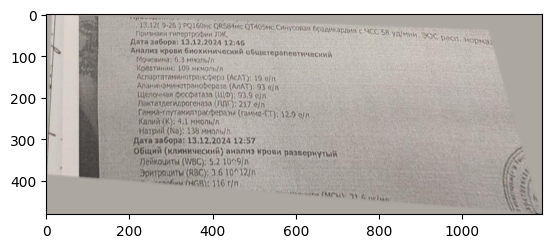

Исправление перспективы завершено. Результат сохранен в файл Output_data/5222040419704106456_warped_image.jpg


In [10]:
import os
import cv2
import numpy as np
from PIL import Image
from collections import Counter
from sklearn.cluster import KMeans

# Функция для вычисления угла линии
def calculate_angle(x1, y1, x2, y2):
    return np.degrees(np.arctan2(y2 - y1, x2 - x1))

# Функция для вычисления расстояния между двумя точками
def calculate_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

# Функция для вычисления длины линии
def calculate_line_length(x1, y1, x2, y2):
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

# Функция для объединения близких линий
def merge_close_lines(lines, distance_threshold=4, angle_threshold=5):
    merged_lines = []
    used_indices = set()

    for i, line1 in enumerate(lines):
        if i in used_indices:
            continue

        x1, y1, x2, y2 = line1
        angle1 = calculate_angle(x1, y1, x2, y2)
        group = [line1]

        for j, line2 in enumerate(lines[i + 1:], start=i + 1):
            if j in used_indices:
                continue

            x3, y3, x4, y4 = line2
            angle2 = calculate_angle(x3, y3, x4, y4)

            # Проверка углового отклонения
            if abs(angle1 - angle2) > angle_threshold:
                continue

            # Проверка близости линий
            center1 = ((x1 + x2) / 2, (y1 + y2) / 2)
            center2 = ((x3 + x4) / 2, (y3 + y4) / 2)
            distance = calculate_distance(center1, center2)

            if distance > distance_threshold:
                continue

            # Если линии близки и углы схожи, добавляем в группу
            group.append(line2)
            used_indices.add(j)

        # Усреднение линий в группе
        if group:
            avg_line = np.mean(group, axis=0).astype(int)
            merged_lines.append(avg_line)
            used_indices.add(i)

    return merged_lines

# Функция для нахождения точки пересечения двух линий
def line_intersection(line1, line2):
    x1, y1, x2, y2 = line1
    x3, y3, x4, y4 = line2

    A1 = y2 - y1
    B1 = x1 - x2
    C1 = A1 * x1 + B1 * y1

    A2 = y4 - y3
    B2 = x3 - x4
    C2 = A2 * x3 + B2 * y3

    determinant = A1 * B2 - A2 * B1

    if determinant == 0:
        return None  # Линии параллельны
    else:
        x = (B2 * C1 - B1 * C2) / determinant
        y = (A1 * C2 - A2 * C1) / determinant
        return int(x), int(y)

# Функция для вычисления центра линии
def calculate_center(x1, y1, x2, y2):
    return ((x1 + x2) // 2, (y1 + y2) // 2)

# Функция для получения доминирующего цвета изображения
def get_dominant_color(image, k=1):
    """
    Возвращает доминирующий цвет изображения с использованием K-means.
    :param image: Изображение в формате BGR.
    :param k: Количество кластеров (по умолчанию 1 для доминирующего цвета).
    :return: Доминирующий цвет в формате BGR.
    """
    # Преобразуем изображение в массив пикселей
    pixels = image.reshape(-1, 3)

    # Применяем K-means для кластеризации
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(pixels)

    # Получаем доминирующий цвет (центр самого большого кластера)
    dominant_color = kmeans.cluster_centers_[0].astype(int)
    return dominant_color

def process_image(image_path):
    # Создаем необходимые директории, если они не существуют
    os.makedirs('resized_data', exist_ok=True)
    os.makedirs('intermediate_results', exist_ok=True)
    os.makedirs('Output_data', exist_ok=True)

    # Загрузка изображения
    image = Image.open(image_path)

    # Вычисление новых размеров с сохранением пропорций
    width = 1000
    ratio = width / float(image.size[0])
    height = int(float(image.size[1]) * ratio)

    # Изменение размера изображения с использованием LANCZOS
    resized_image = image.resize((width, height), Image.Resampling.LANCZOS)

    # Формирование нового имени файла
    directory, filename = os.path.split(image_path)
    name, ext = os.path.splitext(filename)
    new_filename = f"{name}_resized{ext}"
    new_image_path = os.path.join('resized_data/', new_filename)

    # Сохранение измененного изображения
    resized_image.save(new_image_path)

    # Загрузка изображения с помощью OpenCV
    image = cv2.imread(new_image_path, cv2.IMREAD_COLOR)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Применение Canny edge detection
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    # Применение Hough Line Transform
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=50, maxLineGap=10)

    # Преобразование линий в нужный формат
    lines = [line[0] for line in lines]

    # Объединение близких линий
    merged_lines = merge_close_lines(lines, distance_threshold=4, angle_threshold=5)

    # Создание копии изображения для рисования линий
    output_image = image.copy()

    # Получение высоты и ширины изображения
    image_height, image_width, _ = image.shape

    # Словарь для хранения центров линий
    line_centers = {}

    # Отрисовка всех линий и сохранение их центров
    for i, line in enumerate(merged_lines):
        x1, y1, x2, y2 = line
        center = calculate_center(x1, y1, x2, y2)
        line_centers[i] = center
        cv2.line(output_image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Рисуем линии зеленым цветом

    # Фильтрация горизонтальных линий (угол от -40 до 40 градусов)
    middle_third_width_start = 0 #image_width // 3
    middle_third_width_end = image_width // 3 #2 * image_width // 3
    min_horizontal_line_length = image_width / 4

    # Фильтр исключения линий с центрами ближе 10 пикселей к границам
    horizontal_lines = {
        line_id: center for line_id, center in line_centers.items()
        if (middle_third_width_start <= center[0] <= middle_third_width_end) and
           (calculate_line_length(*merged_lines[line_id]) >= min_horizontal_line_length) and
           (-40 <= calculate_angle(*merged_lines[line_id]) <= 40) and
           (10 <= center[0] <= image_width - 10) and  # Фильтр по X
           (10 <= center[1] <= image_height - 10)  # Фильтр по Y
    }

    # Фильтрация вертикальных линий (угол от 50 до 130 градусов)
    middle_third_height_start = image_height // 3
    middle_third_height_end = 2 * image_height // 3
    min_vertical_line_length = image_height / 9

    # Фильтр исключения линий с центрами ближе 20 пикселей к границам
    vertical_lines = {
        line_id: center for line_id, center in line_centers.items()
        if (middle_third_height_start <= center[1] <= middle_third_height_end) and
           (calculate_line_length(*merged_lines[line_id]) >= min_vertical_line_length) and
           (50 <= abs(calculate_angle(*merged_lines[line_id])) <= 130) and
           (20 <= center[0] <= image_width - 20) and  # Фильтр по X
           (20 <= center[1] <= image_height - 20)  # Фильтр по Y
    }

    # Проверка условий для поворота или перспективного преобразования
    need_rotation = False

    if horizontal_lines and vertical_lines:
        # Выбираем две горизонтальные линии (с минимальным и максимальным Y)
        min_y_line = min(horizontal_lines.items(), key=lambda item: item[1][1])
        max_y_line = max(horizontal_lines.items(), key=lambda item: item[1][1])

        # Выбираем две вертикальные линии (с минимальным и максимальным X)
        min_x_line = min(vertical_lines.items(), key=lambda item: item[1][0])
        max_x_line = max(vertical_lines.items(), key=lambda item: item[1][0])

        # Проверяем углы между горизонтальными линиями
        h_line1 = merged_lines[min_y_line[0]]
        h_line2 = merged_lines[max_y_line[0]]
        angle_h1 = calculate_angle(*h_line1)
        angle_h2 = calculate_angle(*h_line2)
        h_angle_diff = abs(angle_h1 - angle_h2)

        # Проверяем углы между вертикальными линиями
        v_line1 = merged_lines[min_x_line[0]]
        v_line2 = merged_lines[max_x_line[0]]
        angle_v1 = calculate_angle(*v_line1)
        angle_v2 = calculate_angle(*v_line2)
        v_angle_diff = abs(angle_v1 - angle_v2)

        # Если углы между линиями отличаются не более чем на 3 градуса, применяем поворот
        if h_angle_diff <= 1 and v_angle_diff <= 1:
            need_rotation = True
        else:
            need_rotation = False
    else:
        need_rotation = True

    if need_rotation:
        # Выбор любых двух линий для вычисления среднего угла
        if len(merged_lines) >= 2:
            line1 = merged_lines[0]
            line2 = merged_lines[1]

            angle1 = calculate_angle(*line1)
            angle2 = calculate_angle(*line2)
            average_angle = (angle1 + angle2) / 2
        else:
            # Если не найдено две линии, используем угол по умолчанию (например, 0 градусов)
            average_angle = 0

        # Получаем доминирующий цвет
        dominant_color = get_dominant_color(image)

        # Вычисляем матрицу поворота
        (h, w) = image.shape[:2]
        center = (w // 2, h // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, average_angle, 1.0)

        # Вычисляем новые размеры холста после поворота
        cos = np.abs(rotation_matrix[0, 0])
        sin = np.abs(rotation_matrix[0, 1])
        new_w = int((h * sin) + (w * cos))
        new_h = int((h * cos) + (w * sin))

        # Корректируем матрицу поворота для учета нового холста
        rotation_matrix[0, 2] += (new_w / 2) - center[0]
        rotation_matrix[1, 2] += (new_h / 2) - center[1]

        # Применяем поворот к изображению с новыми размерами холста
        rotated_image = cv2.warpAffine(
            image,
            rotation_matrix,
            (new_w, new_h),
            flags=cv2.INTER_LINEAR,
            borderMode=cv2.BORDER_CONSTANT,
            borderValue=dominant_color.tolist()
        )

        # Формирование нового имени файла
        directory, filename = os.path.split(image_path)
        name, ext = os.path.splitext(filename)
        new_filename = f"{name}_rotated_image{ext}"
        new_image_path = os.path.join('Output_data/', new_filename)

        # Сохранение результата
        cv2.imwrite(new_image_path, rotated_image)

        # Показ результата (для Jupyter/Colab)
        if 'google.colab' in str(get_ipython()):
            from google.colab.patches import cv2_imshow
            cv2_imshow(rotated_image)
        else:
            from matplotlib import pyplot as plt
            plt.imshow(cv2.cvtColor(rotated_image, cv2.COLOR_BGR2RGB))
            plt.show()

        print("Исправление поворота завершено. Результат сохранен в файл", new_image_path)
        return rotated_image

    else:
        # Получаем координаты линий
        h_line1 = merged_lines[min_y_line[0]]
        h_line2 = merged_lines[max_y_line[0]]
        v_line1 = merged_lines[min_x_line[0]]
        v_line2 = merged_lines[max_x_line[0]]

        # Находим точки пересечения
        intersection_A = line_intersection(h_line1, v_line1)  # Левая верхняя
        intersection_B = line_intersection(h_line2, v_line1)  # Левая нижняя
        intersection_C = line_intersection(h_line1, v_line2)  # Правая верхняя
        intersection_D = line_intersection(h_line2, v_line2)  # Правая нижняя

        # Проверка, что точки пересечения найдены
        if intersection_A and intersection_B and intersection_C and intersection_D:
            # Увеличение изображения
            padding = 0  # Отступ для увеличения изображения
            output_image = cv2.copyMakeBorder(output_image, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=(0, 0, 0))

            # Смещение координат точек пересечения
            intersection_A = (intersection_A[0] + padding, intersection_A[1] + padding)
            intersection_B = (intersection_B[0] + padding, intersection_B[1] + padding)
            intersection_C = (intersection_C[0] + padding, intersection_C[1] + padding)
            intersection_D = (intersection_D[0] + padding, intersection_D[1] + padding)

            # Продление линий до точек пересечения
            cv2.line(output_image, (intersection_A[0], intersection_A[1]), (intersection_C[0], intersection_C[1]), (0, 255, 127), 2)  # Верхняя горизонтальная
            cv2.line(output_image, (intersection_B[0], intersection_B[1]), (intersection_D[0], intersection_D[1]), (0, 255, 127), 2)  # Нижняя горизонтальная
            cv2.line(output_image, (intersection_A[0], intersection_A[1]), (intersection_B[0], intersection_B[1]), (0, 165, 255), 2)  # Левая вертикальная
            cv2.line(output_image, (intersection_C[0], intersection_C[1]), (intersection_D[0], intersection_D[1]), (0, 165, 255), 2)  # Правая вертикальная

            # Подпись точек
            cv2.putText(output_image, "A", (intersection_A[0] - 20, intersection_A[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            cv2.putText(output_image, "B", (intersection_B[0] - 20, intersection_B[1] + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            cv2.putText(output_image, "C", (intersection_C[0] + 10, intersection_C[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            cv2.putText(output_image, "D", (intersection_D[0] + 10, intersection_D[1] + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

            # Сохранение координат точек
            intersections = {
                "A": intersection_A,
                "B": intersection_B,
                "C": intersection_C,
                "D": intersection_D
            }

            # После вычисления реальных размеров прямоугольника
            # Вычисление длин диагоналей на изображении
            diagonal_AB = calculate_distance(intersection_A, intersection_B)
            diagonal_BD = calculate_distance(intersection_B, intersection_D)

            # Отношение AB к стороне BD
            AB_BD_ratio = diagonal_AB / diagonal_BD

            # Предположим, что реальная длина BD известна (например, в метрах)
            real_BD = 1.0  # Например, 1 метр

            # Восстановление истинных размеров прямоугольника
            # Используем пропорции между диагоналями на изображении и реальными размерами
            real_AB = AB_BD_ratio * real_BD

            # Теперь можно вычислить реальные размеры сторон прямоугольника
            # Предположим, что прямоугольник не искажен (т.е. стороны перпендикулярны)
            real_width = real_BD
            real_height = real_AB

            print(f"Истинная ширина прямоугольника: {real_width} метров")
            print(f"Истинная высота прямоугольника: {real_height} метров")

            # Вычисление центра изображения
            center_x = image_width // 2
            center_y = image_height // 2

            # Масштабирование реальных размеров для отображения на изображении
            # Предположим, что 1 метр = 100 пикселей (можно изменить в зависимости от масштаба)
            scale_factor = 100  # 1 метр = 100 пикселей
            rect_width_px = int(real_width * scale_factor)
            rect_height_px = int(real_height * scale_factor)

            # Вычисление координат реального прямоугольника
            rect_top_left = (center_x - rect_width_px // 2, center_y - rect_height_px // 2)
            rect_bottom_right = (center_x + rect_width_px // 2, center_y + rect_height_px // 2)

            # Рисование реального прямоугольника сиреневым цветом
            cv2.rectangle(output_image, rect_top_left, rect_bottom_right, (255, 0, 255), 2)  # Сиреневый цвет (BGR)

            # Указание точек A', B', C', D' на реальном прямоугольнике
            rect_A_prime = (rect_top_left[0], rect_top_left[1])
            rect_B_prime = (rect_top_left[0], rect_bottom_right[1])
            rect_C_prime = (rect_bottom_right[0], rect_top_left[1])
            rect_D_prime = (rect_bottom_right[0], rect_bottom_right[1])

            # Рисование точек и подписей
            cv2.circle(output_image, rect_A_prime, 5, (0, 0, 255), -1)  # Точка A'
            cv2.putText(output_image, "A'", (rect_A_prime[0] - 20, rect_A_prime[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

            cv2.circle(output_image, rect_B_prime, 5, (0, 0, 255), -1)  # Точка B'
            cv2.putText(output_image, "B'", (rect_B_prime[0] - 20, rect_B_prime[1] + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

            cv2.circle(output_image, rect_C_prime, 5, (0, 0, 255), -1)  # Точка C'
            cv2.putText(output_image, "C'", (rect_C_prime[0] + 10, rect_C_prime[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

            cv2.circle(output_image, rect_D_prime, 5, (0, 0, 255), -1)  # Точка D'
            cv2.putText(output_image, "D'", (rect_D_prime[0] + 10, rect_D_prime[1] + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

            # Масштабирование прямоугольника так, чтобы в него вписывался исходный многоугольник ABCD
            # Находим минимальный и максимальный X и Y для исходного многоугольника
            min_x = min(intersection_A[0], intersection_B[0], intersection_C[0], intersection_D[0])
            max_x = max(intersection_A[0], intersection_B[0], intersection_C[0], intersection_D[0])
            min_y = min(intersection_A[1], intersection_B[1], intersection_C[1], intersection_D[1])
            max_y = max(intersection_A[1], intersection_B[1], intersection_C[1], intersection_D[1])

            # Вычисляем ширину и высоту исходного многоугольника
            original_width = max_x - min_x
            original_height = max_y - min_y

            # Вычисляем масштабирующий коэффициент
            scale_x = original_width / rect_width_px
            scale_y = original_height / rect_height_px
            scale_factor_final = max(scale_x, scale_y)  # Используем максимальный коэффициент для вписывания

            # Масштабируем прямоугольник
            scaled_rect_width_px = int(rect_width_px * scale_factor_final)
            scaled_rect_height_px = int(rect_height_px * scale_factor_final)

            # Вычисляем новые координаты масштабированного прямоугольника
            scaled_rect_top_left = (center_x - scaled_rect_width_px // 2, center_y - scaled_rect_height_px // 2)
            scaled_rect_bottom_right = (center_x + scaled_rect_width_px // 2, center_y + scaled_rect_height_px // 2)

            # Рисование масштабированного прямоугольника
            cv2.rectangle(output_image, scaled_rect_top_left, scaled_rect_bottom_right, (0, 255, 0), 2)  # Зеленый цвет (BGR)

            # Вычисление координат точек A'', B'', C'', D'' для масштабированного прямоугольника
            scaled_rect_A_double_prime = (scaled_rect_top_left[0], scaled_rect_top_left[1])
            scaled_rect_B_double_prime = (scaled_rect_top_left[0], scaled_rect_bottom_right[1])
            scaled_rect_C_double_prime = (scaled_rect_bottom_right[0], scaled_rect_top_left[1])
            scaled_rect_D_double_prime = (scaled_rect_bottom_right[0], scaled_rect_bottom_right[1])

            # Вычисление преобразования перспективы
            # Исходные точки (A, B, C, D)
            pts1 = np.float32([intersection_A, intersection_B, intersection_C, intersection_D])

            # Целевые точки (A'', B'', C'', D'')
            pts2 = np.float32([scaled_rect_A_double_prime, scaled_rect_B_double_prime,
                             scaled_rect_C_double_prime, scaled_rect_D_double_prime])

            # Вычисляем матрицу преобразования перспективы
            M = cv2.getPerspectiveTransform(pts1, pts2)

            # Определяем размеры выходного изображения
            # Получаем координаты углов исходного изображения
            h, w = image.shape[:2]
            corners = np.float32([[0, 0], [w, 0], [w, h], [0, h]])

            # Применяем преобразование к углам, чтобы определить новые границы
            transformed_corners = cv2.perspectiveTransform(np.array([corners]), M)[0]

            # Вычисляем новые размеры изображения
            x_min = int(np.min(transformed_corners[:, 0]))
            x_max = int(np.max(transformed_corners[:, 0]))
            y_min = int(np.min(transformed_corners[:, 1]))
            y_max = int(np.max(transformed_corners[:, 1]))

            new_width = x_max - x_min
            new_height = y_max - y_min

            # Создаем матрицу сдвига для корректировки обрезания
            shift_matrix = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]])

            # Объединяем матрицу преобразования и сдвига
            M_shifted = shift_matrix @ M

            # Применяем преобразование перспективы
            warped_image = cv2.warpPerspective(image, M_shifted, (new_width, new_height))

            # Создаем маску для добавленных областей (пустых после преобразования)
            mask = (warped_image == 0).all(axis=2).astype(np.uint8) * 255

            # Находим контуры добавленных областей
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Определяем доминирующий цвет исходного изображения
            dominant_color = get_dominant_color(image)

            # Минимальный размер области для обработки (30 пикселей)
            min_area = 40

            # Обрабатываем только области с размером не менее 30 пикселей
            for contour in contours:
                # Проверяем размер области
                if cv2.contourArea(contour) >= min_area:
                    # Создаем маску для текущей области
                    contour_mask = np.zeros_like(mask)
                    cv2.drawContours(contour_mask, [contour], -1, 255, thickness=cv2.FILLED)

                    # Расширяем маску области на 5 пикселей для захвата окантовки
                    kernel = np.ones((5, 5), np.uint8)  # Ядро для расширения
                    expanded_contour_mask = cv2.dilate(contour_mask, kernel, iterations=1)

                    # Заливаем область и окантовку доминирующим цветом
                    warped_image[expanded_contour_mask == 255] = dominant_color

                    # Размываем края области
                    # Создаем маску для границ (области, где добавленные области встречаются с исходным изображением)
                    border_mask = cv2.Canny(contour_mask, 100, 200)  # Выделяем границы с помощью Canny
                    border_mask = cv2.dilate(border_mask, None, iterations=2)  # Расширяем границы

                    # Применяем размытие только к границам
                    blurred = cv2.GaussianBlur(warped_image, (15, 15), 0)  # Размываем все изображение
                    warped_image[border_mask == 255] = blurred[border_mask == 255]  # Применяем размытие только к границам

            # Формирование нового имени файла
            directory, filename = os.path.split(image_path)
            name, ext = os.path.splitext(filename)
            new_filename = f"{name}_warped_image{ext}"
            new_image_path = os.path.join('Output_data/', new_filename)

            # Сохранение результата
            cv2.imwrite(new_image_path, warped_image)

            # Показ результата (для Jupyter/Colab)
            if 'google.colab' in str(get_ipython()):
                from google.colab.patches import cv2_imshow
                cv2_imshow(warped_image)
            else:
                from matplotlib import pyplot as plt
                plt.imshow(cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB))
                plt.show()

            print("Исправление перспективы завершено. Результат сохранен в файл", new_image_path)
            return warped_image

# Пример использования функции
if __name__ == "__main__":
    image_path = ("input_images/5222040419704106456.jpg")  # Укажите путь к вашему изображению
    result_image = process_image(image_path)